In [1]:
import os
import gensim
from gensim import utils
from tqdm.notebook import tqdm
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.preprocessing import minmax_scale, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import k_means, SpectralClustering
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd

In [2]:
class Dataloader:
    def __iter__(self):
        for genre in tqdm(['ballads', 'elegies', 'songs', 'novels'], leave=True):
            for file in tqdm(os.listdir('../datasets/lemmatized/' + genre), leave=False):
                with open('../datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    yield utils.simple_preprocess(f.read()), genre
sentences = Dataloader()

In [ ]:
#word2vec = gensim.models.Word2Vec(sentences=sentences, vector_size=128, min_count=1)

In [3]:
#word2vec.save('word2vec_model')
word2vec = gensim.models.Word2Vec.load('word2vec_model')
wv = word2vec.wv

In [4]:
#np.random.seed(0)
#random_num = np.random.randint(1826, size=100)
graphs = []
text_len = []
true_labels = []

for num_sentence, (sentence, genre) in enumerate(sentences):
    #if num_sentence not in random_num:
    #    continue
    if not sentence:
        continue
    true_labels.append(genre)
    text_len.append(len(sentence))
    node_type = dict()
    edge_type = dict()
    node_weight = dict()
    nodes = []
    edges = []
    weights = []
    counter = Counter(sentence)
    top10 = counter.most_common(10)
    for word_i, count in top10:
        nodes.append(word_i)
        node_weight[word_i] = count / len(sentence)
        node_type[word_i] = 'core'
        words_in_text = np.array(list(set(sentence)))
        sim = wv.cosine_similarities(wv[word_i], wv[words_in_text])
        neigh_idx = np.argsort(sim)[-11:-1]
        for j in neigh_idx:
            word_j = words_in_text[j]
            if word_j not in nodes:
                nodes.append(word_j)
                node_weight[word_j] = counter[word_j] / len(sentence)
            edges.append([word_i, word_j, sim[j]])
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_weighted_edges_from(edges)
    for node, degree in graph.degree:
        if degree == 1:
            node_type[node] = 'boundary'
    for node in set(graph.nodes).difference(node_type.keys()):
        node_type[node] = 'multiple'
    nx.set_node_attributes(graph, node_type, 'node_type')
    nx.set_node_attributes(graph, node_weight, 'node_weight')
    for (u, v) in graph.edges:
        types = set(nx.get_node_attributes(graph.subgraph([u, v]), 'node_type').values())
        if types == {'core'}:
            edge_type[(u, v)] = 'core'
        elif types == {'core', 'multiple'}:
            edge_type[(u, v)] = 'multiple'
        else:
            edge_type[(u, v)] = 'boundary'
    nx.set_edge_attributes(graph, edge_type, 'edge_type')
    graphs.append(graph)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

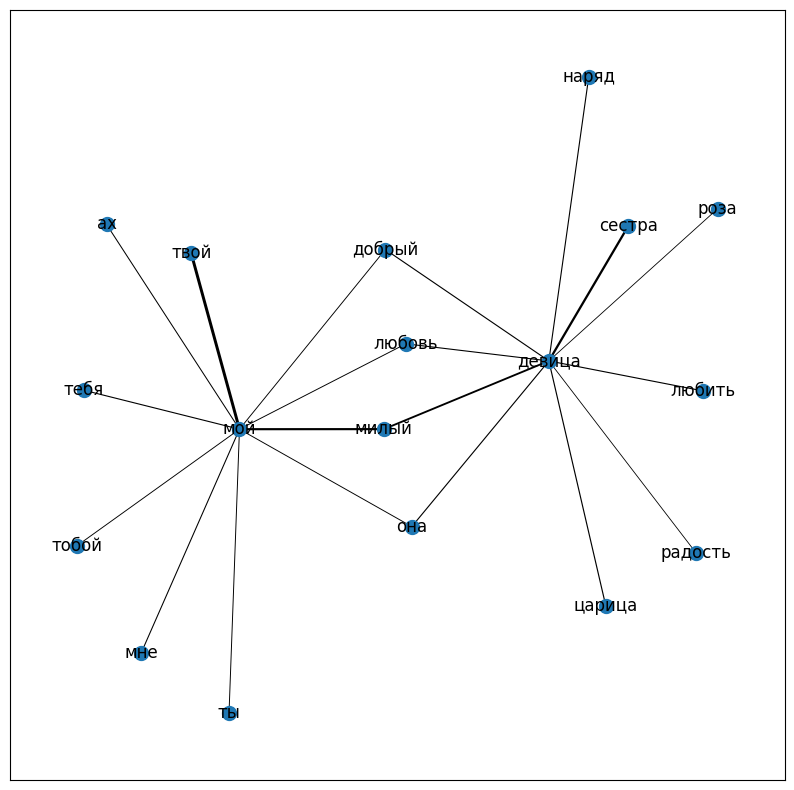

In [5]:
plt.figure(figsize=(10, 10))
graph = nx.Graph(graphs[0])
cc_nodes = list(nx.connected_components(graph))[0]
subgraph = graph.subgraph(cc_nodes)
weights = np.array(list(nx.get_edge_attributes(subgraph, 'weight').values()))
nx.draw_networkx(subgraph, node_size=100, width=(weights + 0.5)**4)

In [6]:
core_edges = []
multiple_edges = []
boundary_edges = []
multiple_nodes = []
boundary_nodes = []

min_core_node_weight = []
max_core_node_weight = []
avg_core_node_weight = []
sum_core_node_weight = []
min_multiple_node_weight = []
max_multiple_node_weight = []
avg_multiple_node_weight = []
sum_multiple_node_weight = []
min_boundary_node_weight = []
max_boundary_node_weight = []
avg_boundary_node_weight = []
sum_boundary_node_weight = []

min_core_edge_weight = []
max_core_edge_weight = []
avg_core_edge_weight = []
sum_core_edge_weight = []
min_multiple_edge_weight = []
max_multiple_edge_weight = []
avg_multiple_edge_weight = []
sum_multiple_edge_weight = []
min_boundary_edge_weight = []
max_boundary_edge_weight = []
avg_boundary_edge_weight = []
sum_boundary_edge_weight = []

min_core_core_degree = []
max_core_core_degree = []
avg_core_core_degree = []
sum_core_core_degree = []
min_core_multiple_degree = []
max_core_multiple_degree = []
avg_core_multiple_degree = []
sum_core_multiple_degree = []
min_core_boundary_degree = []
max_core_boundary_degree = []
avg_core_boundary_degree = []
sum_core_boundary_degree = []

for graph in tqdm(graphs):
    edge_counter = Counter(nx.get_edge_attributes(graph, 'edge_type').values())
    node_counter = Counter(nx.get_node_attributes(graph, 'node_type').values())
    core_edges.append(edge_counter['core'])
    multiple_edges.append(edge_counter['multiple'])
    boundary_edges.append(edge_counter['boundary'])
    multiple_nodes.append(node_counter['multiple'])
    boundary_nodes.append(node_counter['boundary'])
    
    # node aggregation
    core_node_weight = []
    multiple_node_weight = []
    boundary_node_weight = []
    for node in graph.nodes:
        if graph.nodes[node]['node_type'] == 'core':
            core_node_weight.append(graph.nodes[node]['node_weight'])
        elif graph.nodes[node]['node_type'] == 'multiple':
            multiple_node_weight.append(graph.nodes[node]['node_weight'])
        else:
            boundary_node_weight.append(graph.nodes[node]['node_weight'])
    min_core_node_weight.append(min(core_node_weight))
    max_core_node_weight.append(max(core_node_weight))
    avg_core_node_weight.append(np.mean(core_node_weight))
    sum_core_node_weight.append(sum(core_node_weight))
    min_multiple_node_weight.append(min(multiple_node_weight))
    max_multiple_node_weight.append(max(multiple_node_weight))
    avg_multiple_node_weight.append(np.mean(multiple_node_weight))
    sum_multiple_node_weight.append(sum(multiple_node_weight))
    boundary_node_weight = [0] if not boundary_node_weight else boundary_node_weight
    min_boundary_node_weight.append(min(boundary_node_weight))
    max_boundary_node_weight.append(max(boundary_node_weight))
    avg_boundary_node_weight.append(np.mean(boundary_node_weight))
    sum_boundary_node_weight.append(sum(boundary_node_weight))
    
    # edge aggregation
    core_edge_weight = []
    multiple_edge_weight = []
    boundary_edge_weight = []
    for edge in graph.edges:
        if graph.edges[edge]['edge_type'] == 'core':
            core_edge_weight.append(graph.edges[edge]['weight'])
        elif graph.edges[edge]['edge_type'] == 'multiple':
            multiple_edge_weight.append(graph.edges[edge]['weight'])
        else:
            boundary_edge_weight.append(graph.edges[edge]['weight'])
    core_edge_weight = [0] if not core_edge_weight else core_edge_weight
    min_core_edge_weight.append(min(core_edge_weight))
    max_core_edge_weight.append(max(core_edge_weight))
    avg_core_edge_weight.append(np.mean(core_edge_weight))
    sum_core_edge_weight.append(sum(core_edge_weight))
    min_multiple_edge_weight.append(min(multiple_edge_weight))
    max_multiple_edge_weight.append(max(multiple_edge_weight))
    avg_multiple_edge_weight.append(np.mean(multiple_edge_weight))
    sum_multiple_edge_weight.append(sum(multiple_edge_weight))
    boundary_edge_weight = [0] if not boundary_edge_weight else boundary_edge_weight
    min_boundary_edge_weight.append(min(boundary_edge_weight))
    max_boundary_edge_weight.append(max(boundary_edge_weight))
    avg_boundary_edge_weight.append(np.mean(boundary_edge_weight))
    sum_boundary_edge_weight.append(sum(boundary_edge_weight))
    
    # degree aggregation
    core_core_degree = []
    core_multiple_degree = []
    core_boundary_degree = []
    for core_node in graph.nodes:
        if graph.nodes[core_node]['node_type'] != 'core':
            continue
        degree_counter = Counter([value for (u, v, value) in graph.edges(core_node, data='edge_type')])
        core_core_degree.append(degree_counter['core'])
        core_multiple_degree.append(degree_counter['multiple'])
        core_boundary_degree.append(degree_counter['boundary'])
    
    min_core_core_degree.append(min(core_core_degree))
    max_core_core_degree.append(max(core_core_degree))
    avg_core_core_degree.append(np.mean(core_core_degree))
    sum_core_core_degree.append(sum(core_core_degree))
    min_core_multiple_degree.append(min(core_multiple_degree))
    max_core_multiple_degree.append(max(core_multiple_degree))
    avg_core_multiple_degree.append(np.mean(core_multiple_degree))
    sum_core_multiple_degree.append(sum(core_multiple_degree))
    core_boundary_degree = [0] if not core_boundary_degree else core_boundary_degree
    min_core_boundary_degree.append(min(core_boundary_degree))
    max_core_boundary_degree.append(max(core_boundary_degree))
    avg_core_boundary_degree.append(np.mean(core_boundary_degree))
    sum_core_boundary_degree.append(sum(core_boundary_degree))

  0%|          | 0/1826 [00:00<?, ?it/s]

In [7]:
graph_feat = pd.DataFrame({
    'text_len': text_len,
    'core_edges': core_edges,
    'multiple_edges': multiple_edges,
    'boundary_edges': boundary_edges,
    'multiple_nodes': multiple_nodes,
    'boundary_nodes': boundary_nodes,
    'min_core_node_weight': min_core_node_weight,
    'max_core_node_weight': max_core_node_weight,
    'avg_core_node_weight': avg_core_node_weight,
    'sum_core_node_weight': sum_core_node_weight,
    'min_multiple_node_weight': min_multiple_node_weight,
    'max_multiple_node_weight': max_multiple_node_weight,
    'avg_multiple_node_weight': avg_multiple_node_weight,
    'sum_multiple_node_weight': sum_multiple_node_weight,
    'min_boundary_node_weight': min_boundary_node_weight,
    'max_boundary_node_weight': max_boundary_node_weight,
    'avg_boundary_node_weight': avg_boundary_node_weight,
    'sum_boundary_node_weight': sum_boundary_node_weight,
    'min_core_edge_weight': min_core_edge_weight,
    'max_core_edge_weight': max_core_edge_weight,
    'avg_core_edge_weight': avg_core_edge_weight,
    'sum_core_edge_weight': sum_core_edge_weight,
    'min_multiple_edge_weight': min_multiple_edge_weight,
    'max_multiple_edge_weight': max_multiple_edge_weight,
    'avg_multiple_edge_weight': avg_multiple_edge_weight,
    'sum_multiple_edge_weight': sum_multiple_edge_weight,
    'min_boundary_edge_weight': min_boundary_edge_weight,
    'max_boundary_edge_weight': max_boundary_edge_weight,
    'avg_boundary_edge_weight': avg_boundary_edge_weight,
    'sum_boundary_edge_weight': sum_boundary_edge_weight,
    'min_core_core_degree': min_core_core_degree,
    'max_core_core_degree': max_core_core_degree,
    'avg_core_core_degree': avg_core_core_degree,
    'sum_core_core_degree': sum_core_core_degree,
    'min_core_multiple_degree': min_core_multiple_degree,
    'max_core_multiple_degree': max_core_multiple_degree,
    'avg_core_multiple_degree': avg_core_multiple_degree,
    'sum_core_multiple_degree': sum_core_multiple_degree,
    'min_core_boundary_degree': min_core_boundary_degree,
    'max_core_boundary_degree': max_core_boundary_degree,
    'avg_core_boundary_degree': avg_core_boundary_degree,
    'sum_core_boundary_degree': sum_core_boundary_degree,
})
graph_feat.iloc[0]

text_len                    217.000000
core_edges                   21.000000
multiple_edges               37.000000
boundary_edges               24.000000
multiple_nodes               11.000000
boundary_nodes               24.000000
min_core_node_weight          0.023041
max_core_node_weight          0.036866
avg_core_node_weight          0.029032
sum_core_node_weight          0.290323
min_multiple_node_weight      0.004608
max_multiple_node_weight      0.009217
avg_multiple_node_weight      0.007122
sum_multiple_node_weight      0.078341
min_boundary_node_weight      0.004608
max_boundary_node_weight      0.023041
avg_boundary_node_weight      0.007680
sum_boundary_node_weight      0.184332
min_core_edge_weight          0.732022
max_core_edge_weight          0.958177
avg_core_edge_weight          0.856555
sum_core_edge_weight         17.987651
min_multiple_edge_weight      0.404699
max_multiple_edge_weight      0.862086
avg_multiple_edge_weight      0.733216
sum_multiple_edge_weight 

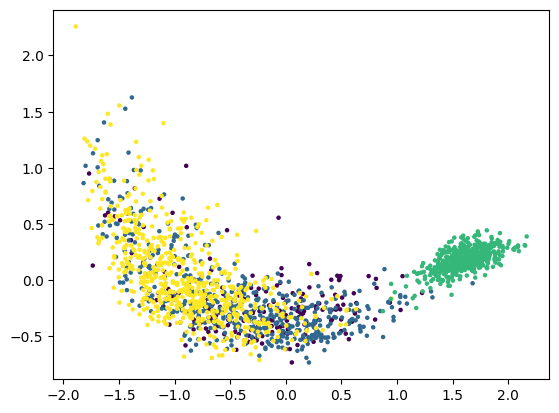

In [8]:
pca = PCA(n_components=16)
emb = pca.fit_transform(minmax_scale(graph_feat))
plt.scatter(emb[:, 0], emb[:, 1], c=LabelEncoder().fit_transform(true_labels), s=5);

In [9]:
clustering = SpectralClustering(
    n_clusters=4, 
    n_neighbors=6,
    affinity='nearest_neighbors',
    assign_labels='kmeans',
)
pred_labels = clustering.fit_predict(emb)

In [10]:
print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, pred_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, pred_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, pred_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, pred_labels):.4f}'''
)

homogeneity_score: 0.4405
completeness_score: 0.7088
v_measure_score: 0.5433
adjusted_rand_score: 0.3206


In [11]:
graph_words = []
jaccard = []

for graph in graphs:
    nodes = [node for node in graph.nodes]
    graph_words.append(set(nodes))

for set_1 in graph_words:
    jaccard_row = []
    for set_2 in graph_words:
        jaccard_pair = gensim.matutils.jaccard_distance(set_1, set_2)
        jaccard_row.append(jaccard_pair)
    jaccard.append(jaccard_row)

In [14]:
clustering_ = SpectralClustering(
    n_clusters=4, 
    n_neighbors=6,
    assign_labels='kmeans',
    affinity = 'precomputed',
)
jaccard_labels = clustering_.fit_predict(minmax_scale(np.array(jaccard)))
print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, jaccard_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, jaccard_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, jaccard_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, jaccard_labels):.4f}'''
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


homogeneity_score: 0.0019
completeness_score: 0.0993
v_measure_score: 0.0037
adjusted_rand_score: 0.0006


In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
concat_labels = kmeans.fit_predict(np.column_stack((pred_labels, jaccard_labels)))
print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, concat_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, concat_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, concat_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, concat_labels):.4f}'''
)

homogeneity_score: 0.4236
completeness_score: 0.6860
v_measure_score: 0.5238
adjusted_rand_score: 0.3185


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
graph_feat_jaccard = clustering.fit_predict(minmax_scale(np.column_stack((graph_feat, jaccard_labels))))
print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, graph_feat_jaccard):.4f}
completeness_score: {metrics.completeness_score(true_labels, graph_feat_jaccard):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, graph_feat_jaccard):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, graph_feat_jaccard):.4f}'''
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


homogeneity_score: 0.4827
completeness_score: 0.5754
v_measure_score: 0.5250
adjusted_rand_score: 0.4663


In [40]:
graph_feat.to_csv('graph_feat.csv', index=False)

authors for novels

In [2]:
class Dataloader:
    def __iter__(self):
        for genre in ['ballads', 'elegies', 'songs', 'novels']:
            for file in os.listdir('../datasets/lemmatized/' + genre):
                with open('../datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    fname = '../datasets/lemmatized/' + genre + '/' + file
                    if genre == 'novels':
                        author = file.split('.')[0]
                    elif genre == 'ballads':
                        author = file.split('_')[2]
                    else:
                        author = file.split('_')[1]
                    yield utils.simple_preprocess(f.read()), genre, author, fname
sentences = Dataloader()

fnames = []
texts = []
true_labels = []
authors = []

for (sent, genre, author, fname) in sentences:
    if not sent:
        continue
    texts. append(sent)
    true_labels.append(genre)
    authors.append(author)
    fnames.append(fname)

In [3]:
novels = [num for num, genre in enumerate(true_labels) if genre == 'novels']
novels_text = [text for num, text in enumerate(texts) if num in novels]
novels_authors = [text for num, text in enumerate(authors) if num in novels]
selected_authors = [i[0] for i in Counter(novels_authors).most_common(10)]
indeces = [num for num, author in enumerate(authors) if author in selected_authors]

sentences = [texts[num] for num in indeces]

In [17]:
true_labels = [authors[num] for num in indeces]

In [4]:
word2vec = gensim.models.Word2Vec.load('word2vec_model')
wv = word2vec.wv

In [5]:
graphs = []
text_len = []
true_labels = []

for num_sentence, sentence in enumerate(sentences):
    #if num_sentence not in random_num:
    #    continue
    if not sentence:
        continue
    text_len.append(len(sentence))
    node_type = dict()
    edge_type = dict()
    node_weight = dict()
    nodes = []
    edges = []
    weights = []
    counter = Counter(sentence)
    top10 = counter.most_common(10)
    for word_i, count in top10:
        nodes.append(word_i)
        node_weight[word_i] = count / len(sentence)
        node_type[word_i] = 'core'
        words_in_text = np.array(list(set(sentence)))
        sim = wv.cosine_similarities(wv[word_i], wv[words_in_text])
        neigh_idx = np.argsort(sim)[-11:-1]
        for j in neigh_idx:
            word_j = words_in_text[j]
            if word_j not in nodes:
                nodes.append(word_j)
                node_weight[word_j] = counter[word_j] / len(sentence)
            edges.append([word_i, word_j, sim[j]])
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_weighted_edges_from(edges)
    for node, degree in graph.degree:
        if degree == 1:
            node_type[node] = 'boundary'
    for node in set(graph.nodes).difference(node_type.keys()):
        node_type[node] = 'multiple'
    nx.set_node_attributes(graph, node_type, 'node_type')
    nx.set_node_attributes(graph, node_weight, 'node_weight')
    for (u, v) in graph.edges:
        types = set(nx.get_node_attributes(graph.subgraph([u, v]), 'node_type').values())
        if types == {'core'}:
            edge_type[(u, v)] = 'core'
        elif types == {'core', 'multiple'}:
            edge_type[(u, v)] = 'multiple'
        else:
            edge_type[(u, v)] = 'boundary'
    nx.set_edge_attributes(graph, edge_type, 'edge_type')
    graphs.append(graph)

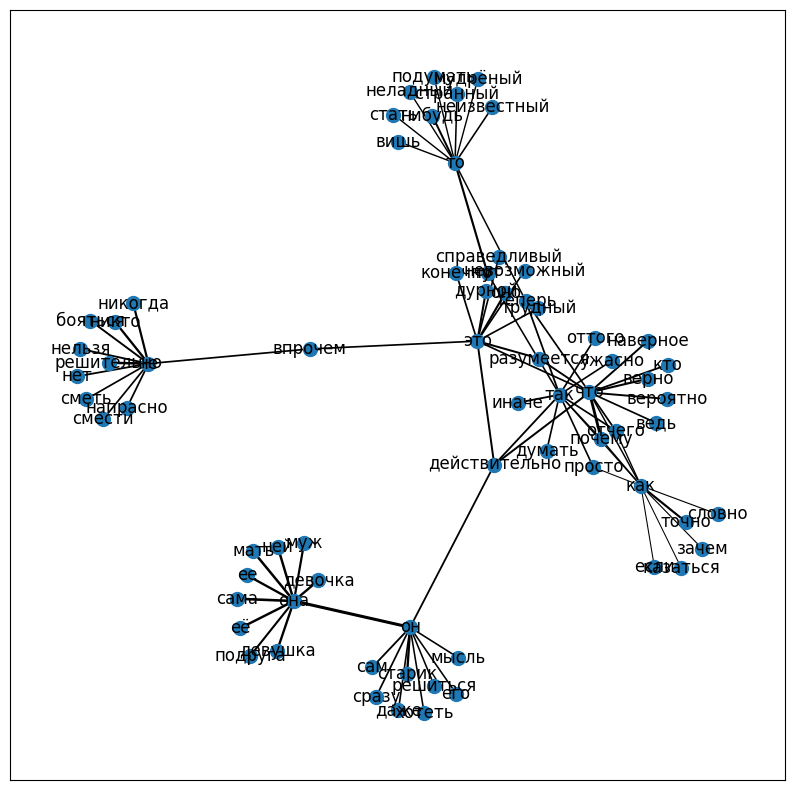

In [9]:
plt.figure(figsize=(10, 10))
graph = nx.Graph(graphs[1])
cc_nodes = list(nx.connected_components(graph))[0]
subgraph = graph.subgraph(cc_nodes)
weights = np.array(list(nx.get_edge_attributes(subgraph, 'weight').values()))
nx.draw_networkx(subgraph, node_size=100, width=(weights + 0.5)**4)

In [10]:
core_edges = []
multiple_edges = []
boundary_edges = []
multiple_nodes = []
boundary_nodes = []

min_core_node_weight = []
max_core_node_weight = []
avg_core_node_weight = []
sum_core_node_weight = []
min_multiple_node_weight = []
max_multiple_node_weight = []
avg_multiple_node_weight = []
sum_multiple_node_weight = []
min_boundary_node_weight = []
max_boundary_node_weight = []
avg_boundary_node_weight = []
sum_boundary_node_weight = []

min_core_edge_weight = []
max_core_edge_weight = []
avg_core_edge_weight = []
sum_core_edge_weight = []
min_multiple_edge_weight = []
max_multiple_edge_weight = []
avg_multiple_edge_weight = []
sum_multiple_edge_weight = []
min_boundary_edge_weight = []
max_boundary_edge_weight = []
avg_boundary_edge_weight = []
sum_boundary_edge_weight = []

min_core_core_degree = []
max_core_core_degree = []
avg_core_core_degree = []
sum_core_core_degree = []
min_core_multiple_degree = []
max_core_multiple_degree = []
avg_core_multiple_degree = []
sum_core_multiple_degree = []
min_core_boundary_degree = []
max_core_boundary_degree = []
avg_core_boundary_degree = []
sum_core_boundary_degree = []

for graph in tqdm(graphs):
    edge_counter = Counter(nx.get_edge_attributes(graph, 'edge_type').values())
    node_counter = Counter(nx.get_node_attributes(graph, 'node_type').values())
    core_edges.append(edge_counter['core'])
    multiple_edges.append(edge_counter['multiple'])
    boundary_edges.append(edge_counter['boundary'])
    multiple_nodes.append(node_counter['multiple'])
    boundary_nodes.append(node_counter['boundary'])
    
    # node aggregation
    core_node_weight = []
    multiple_node_weight = []
    boundary_node_weight = []
    for node in graph.nodes:
        if graph.nodes[node]['node_type'] == 'core':
            core_node_weight.append(graph.nodes[node]['node_weight'])
        elif graph.nodes[node]['node_type'] == 'multiple':
            multiple_node_weight.append(graph.nodes[node]['node_weight'])
        else:
            boundary_node_weight.append(graph.nodes[node]['node_weight'])
    min_core_node_weight.append(min(core_node_weight))
    max_core_node_weight.append(max(core_node_weight))
    avg_core_node_weight.append(np.mean(core_node_weight))
    sum_core_node_weight.append(sum(core_node_weight))
    min_multiple_node_weight.append(min(multiple_node_weight))
    max_multiple_node_weight.append(max(multiple_node_weight))
    avg_multiple_node_weight.append(np.mean(multiple_node_weight))
    sum_multiple_node_weight.append(sum(multiple_node_weight))
    boundary_node_weight = [0] if not boundary_node_weight else boundary_node_weight
    min_boundary_node_weight.append(min(boundary_node_weight))
    max_boundary_node_weight.append(max(boundary_node_weight))
    avg_boundary_node_weight.append(np.mean(boundary_node_weight))
    sum_boundary_node_weight.append(sum(boundary_node_weight))
    
    # edge aggregation
    core_edge_weight = []
    multiple_edge_weight = []
    boundary_edge_weight = []
    for edge in graph.edges:
        if graph.edges[edge]['edge_type'] == 'core':
            core_edge_weight.append(graph.edges[edge]['weight'])
        elif graph.edges[edge]['edge_type'] == 'multiple':
            multiple_edge_weight.append(graph.edges[edge]['weight'])
        else:
            boundary_edge_weight.append(graph.edges[edge]['weight'])
    core_edge_weight = [0] if not core_edge_weight else core_edge_weight
    min_core_edge_weight.append(min(core_edge_weight))
    max_core_edge_weight.append(max(core_edge_weight))
    avg_core_edge_weight.append(np.mean(core_edge_weight))
    sum_core_edge_weight.append(sum(core_edge_weight))
    min_multiple_edge_weight.append(min(multiple_edge_weight))
    max_multiple_edge_weight.append(max(multiple_edge_weight))
    avg_multiple_edge_weight.append(np.mean(multiple_edge_weight))
    sum_multiple_edge_weight.append(sum(multiple_edge_weight))
    boundary_edge_weight = [0] if not boundary_edge_weight else boundary_edge_weight
    min_boundary_edge_weight.append(min(boundary_edge_weight))
    max_boundary_edge_weight.append(max(boundary_edge_weight))
    avg_boundary_edge_weight.append(np.mean(boundary_edge_weight))
    sum_boundary_edge_weight.append(sum(boundary_edge_weight))
    
    # degree aggregation
    core_core_degree = []
    core_multiple_degree = []
    core_boundary_degree = []
    for core_node in graph.nodes:
        if graph.nodes[core_node]['node_type'] != 'core':
            continue
        degree_counter = Counter([value for (u, v, value) in graph.edges(core_node, data='edge_type')])
        core_core_degree.append(degree_counter['core'])
        core_multiple_degree.append(degree_counter['multiple'])
        core_boundary_degree.append(degree_counter['boundary'])
    
    min_core_core_degree.append(min(core_core_degree))
    max_core_core_degree.append(max(core_core_degree))
    avg_core_core_degree.append(np.mean(core_core_degree))
    sum_core_core_degree.append(sum(core_core_degree))
    min_core_multiple_degree.append(min(core_multiple_degree))
    max_core_multiple_degree.append(max(core_multiple_degree))
    avg_core_multiple_degree.append(np.mean(core_multiple_degree))
    sum_core_multiple_degree.append(sum(core_multiple_degree))
    core_boundary_degree = [0] if not core_boundary_degree else core_boundary_degree
    min_core_boundary_degree.append(min(core_boundary_degree))
    max_core_boundary_degree.append(max(core_boundary_degree))
    avg_core_boundary_degree.append(np.mean(core_boundary_degree))
    sum_core_boundary_degree.append(sum(core_boundary_degree))

  0%|          | 0/148 [00:00<?, ?it/s]

In [11]:
graph_feat = pd.DataFrame({
    'text_len': text_len,
    'core_edges': core_edges,
    'multiple_edges': multiple_edges,
    'boundary_edges': boundary_edges,
    'multiple_nodes': multiple_nodes,
    'boundary_nodes': boundary_nodes,
    'min_core_node_weight': min_core_node_weight,
    'max_core_node_weight': max_core_node_weight,
    'avg_core_node_weight': avg_core_node_weight,
    'sum_core_node_weight': sum_core_node_weight,
    'min_multiple_node_weight': min_multiple_node_weight,
    'max_multiple_node_weight': max_multiple_node_weight,
    'avg_multiple_node_weight': avg_multiple_node_weight,
    'sum_multiple_node_weight': sum_multiple_node_weight,
    'min_boundary_node_weight': min_boundary_node_weight,
    'max_boundary_node_weight': max_boundary_node_weight,
    'avg_boundary_node_weight': avg_boundary_node_weight,
    'sum_boundary_node_weight': sum_boundary_node_weight,
    'min_core_edge_weight': min_core_edge_weight,
    'max_core_edge_weight': max_core_edge_weight,
    'avg_core_edge_weight': avg_core_edge_weight,
    'sum_core_edge_weight': sum_core_edge_weight,
    'min_multiple_edge_weight': min_multiple_edge_weight,
    'max_multiple_edge_weight': max_multiple_edge_weight,
    'avg_multiple_edge_weight': avg_multiple_edge_weight,
    'sum_multiple_edge_weight': sum_multiple_edge_weight,
    'min_boundary_edge_weight': min_boundary_edge_weight,
    'max_boundary_edge_weight': max_boundary_edge_weight,
    'avg_boundary_edge_weight': avg_boundary_edge_weight,
    'sum_boundary_edge_weight': sum_boundary_edge_weight,
    'min_core_core_degree': min_core_core_degree,
    'max_core_core_degree': max_core_core_degree,
    'avg_core_core_degree': avg_core_core_degree,
    'sum_core_core_degree': sum_core_core_degree,
    'min_core_multiple_degree': min_core_multiple_degree,
    'max_core_multiple_degree': max_core_multiple_degree,
    'avg_core_multiple_degree': avg_core_multiple_degree,
    'sum_core_multiple_degree': sum_core_multiple_degree,
    'min_core_boundary_degree': min_core_boundary_degree,
    'max_core_boundary_degree': max_core_boundary_degree,
    'avg_core_boundary_degree': avg_core_boundary_degree,
    'sum_core_boundary_degree': sum_core_boundary_degree,
})
graph_feat.iloc[0]

text_len                    183166.000000
core_edges                       3.000000
multiple_edges                  19.000000
boundary_edges                  78.000000
multiple_nodes                   8.000000
boundary_nodes                  78.000000
min_core_node_weight             0.009685
max_core_node_weight             0.028362
avg_core_node_weight             0.015333
sum_core_node_weight             0.153331
min_multiple_node_weight         0.000082
max_multiple_node_weight         0.003625
avg_multiple_node_weight         0.000978
sum_multiple_node_weight         0.007824
min_boundary_node_weight         0.000005
max_boundary_node_weight         0.007376
avg_boundary_node_weight         0.000881
sum_boundary_node_weight         0.068703
min_core_edge_weight             0.512265
max_core_edge_weight             0.551240
avg_core_edge_weight             0.530462
sum_core_edge_weight             1.591387
min_multiple_edge_weight         0.493182
max_multiple_edge_weight         0

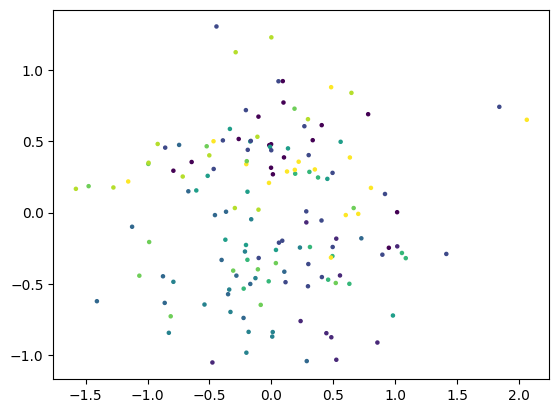

In [19]:
pca = PCA(n_components=16)
emb = pca.fit_transform(minmax_scale(graph_feat))
plt.scatter(emb[:, 0], emb[:, 1], c=LabelEncoder().fit_transform(true_labels), s=5)

In [20]:
clustering = SpectralClustering(
    n_clusters=4, 
    n_neighbors=6,
    affinity='nearest_neighbors',
    assign_labels='kmeans',
)
pred_labels = clustering.fit_predict(emb)

In [21]:
print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, pred_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, pred_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, pred_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, pred_labels):.4f}'''
)

homogeneity_score: 0.2226
completeness_score: 0.3678
v_measure_score: 0.2773
adjusted_rand_score: 0.1451
